In [1]:
import os
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime

In [3]:
path = Path('/kaggle/input/larger-whoop-data')
df = pd.read_csv(path/'physiological_cycles.csv')

In [4]:
def preprocess_data(df):
    df_clean = df.copy()

    if 'Sleep efficiency %' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['Sleep efficiency %'])

    if 'Asleep duration (min)' in df_clean.columns:
        df_clean = df_clean[df_clean['Asleep duration (min)'] >= 300]

    if all(col in df_clean.columns for col in [
        'Deep (SWS) duration (min)',
        'REM duration (min)',
        'Light sleep duration (min)',
        'Asleep duration (min)'
    ]):
        df_clean['Deep sleep ratio'] = df_clean['Deep (SWS) duration (min)'] / df_clean['Asleep duration (min)']
        df_clean['REM sleep ratio'] = df_clean['REM duration (min)'] / df_clean['Asleep duration (min)']
        df_clean['Light sleep ratio'] = df_clean['Light sleep duration (min)'] / df_clean['Asleep duration (min)']
        
    columns_to_drop = [
        'Cycle start time',
        'Cycle end time',
        'Cycle timezone',
        'Day Strain',
        'Energy burned (cal)',
        'Max HR (bpm)',
        'Average HR (bpm)',
        'Sleep onset',
        'Wake onset',
        'Sleep consistency %',
    ]
    
    columns_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
    df_clean = df_clean.drop(columns=columns_to_drop)

    numeric_columns = df_clean.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        
    return df_clean

In [5]:
df.columns

Index(['Cycle start time', 'Cycle end time', 'Cycle timezone',
       'Recovery score %', 'Resting heart rate (bpm)',
       'Heart rate variability (ms)', 'Skin temp (celsius)', 'Blood oxygen %',
       'Day Strain', 'Energy burned (cal)', 'Max HR (bpm)', 'Average HR (bpm)',
       'Sleep onset', 'Wake onset', 'Sleep performance %',
       'Respiratory rate (rpm)', 'Asleep duration (min)',
       'In bed duration (min)', 'Light sleep duration (min)',
       'Deep (SWS) duration (min)', 'REM duration (min)',
       'Awake duration (min)', 'Sleep need (min)', 'Sleep debt (min)',
       'Sleep efficiency %', 'Sleep consistency %'],
      dtype='object')

In [6]:
df_clean = preprocess_data(df)
df_clean.head()

,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Skin temp (celsius),Blood oxygen %,Sleep performance %,Respiratory rate (rpm),Asleep duration (min),In bed duration (min),Light sleep duration (min),Deep (SWS) duration (min),REM duration (min),Awake duration (min),Sleep need (min),Sleep debt (min),Sleep efficiency %,Deep sleep ratio,REM sleep ratio,Light sleep ratio
0,72.0,55.0,47.0,33.86,97.56,66.0,14.1,394.0,450.0,133.0,129.0,132.0,56.0,595.0,123.0,87.0,0.327411,0.335025,0.337563
2,55.0,64.0,39.0,31.68,97.92,60.0,14.5,367.0,419.0,152.0,149.0,66.0,52.0,615.0,108.0,87.0,0.405995,0.179837,0.414169
3,43.0,62.0,34.0,32.20,97.17,59.0,14.9,314.0,367.0,139.0,87.0,88.0,53.0,530.0,9.0,85.0,0.277070,0.280255,0.442675
4,58.0,64.0,38.0,32.72,97.33,97.0,14.8,548.0,632.0,279.0,134.0,135.0,84.0,564.0,91.0,86.0,0.244526,0.246350,0.509124
5,21.0,77.0,22.0,33.91,97.45,75.0,15.2,416.0,469.0,214.0,111.0,91.0,53.0,558.0,85.0,88.0,0.266827,0.218750,0.514423


In [7]:
df_clean, test_df_clean = train_test_split(df_clean, test_size=0.2, random_state=42)

In [8]:
df_clean.shape

(508, 19)

In [9]:
test_df_clean.shape

(128, 19)

In [10]:
def model_prep(df, target_col='Recovery score %'):
    df_model = df.copy()

    y = df_model[target_col]
    X = df_model.drop(columns=[target_col])

    for col in X.select_dtypes(include=['object']).columns:
        X[col] = pd.to_numeric(X[col], errors='ignore')

    X = X.select_dtypes(include=np.number)

    return X, y

In [11]:
def train_xgboost_kfold_early_stop(X, y, n_splits=5, RANDOM_STATE=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    val_scores = []
    rmse_scores = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.025,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=RANDOM_STATE
        )
        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            early_stopping_rounds=25,
            verbose=False
        )
        preds = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        r2 = r2_score(y_val_fold, preds)
        val_scores.append(r2)
        rmse_scores.append(rmse)
        print(f"Fold {fold+1} — R2: {r2:.4f}, RMSE: {rmse:.4f}, Estimators used: {model.best_iteration + 1}")

    print(f"\n📊 Cross-Validation with Early Stopping Results ({n_splits}-fold):")
    print(f"Avg R²: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
    print(f"Avg RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    return model

In [12]:
X, y = model_prep(df_clean)
X

,Resting heart rate (bpm),Heart rate variability (ms),Skin temp (celsius),Blood oxygen %,Sleep performance %,Respiratory rate (rpm),Asleep duration (min),In bed duration (min),Light sleep duration (min),Deep (SWS) duration (min),REM duration (min),Awake duration (min),Sleep need (min),Sleep debt (min),Sleep efficiency %,Deep sleep ratio,REM sleep ratio,Light sleep ratio
395,87.0,12.0,34.00,97.41,60.0,15.4,351.0,444.0,202.0,106.0,43.0,93.0,590.0,84.0,79.0,0.301994,0.122507,0.575499
251,53.0,32.0,32.20,98.50,58.0,14.9,347.0,400.0,153.0,70.0,124.0,53.0,601.0,127.0,87.0,0.201729,0.357349,0.440922
380,58.0,68.0,34.00,95.63,81.0,14.5,472.0,549.0,189.0,106.0,177.0,77.0,586.0,112.0,86.0,0.224576,0.375000,0.400424
112,57.0,46.0,33.16,96.65,76.0,13.9,441.0,479.0,178.0,120.0,143.0,38.0,578.0,90.0,92.0,0.272109,0.324263,0.403628
122,51.0,48.0,33.10,97.21,73.0,14.1,403.0,485.0,170.0,84.0,149.0,82.0,555.0,83.0,82.0,0.208437,0.369727,0.421836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,58.0,44.0,34.10,97.45,64.0,13.9,363.0,457.0,135.0,120.0,108.0,94.0,568.0,95.0,79.0,0.330579,0.297521,0.371901
114,50.0,62.0,31.94,98.20,64.0,14.5,370.0,467.0,104.0,124.0,142.0,97.0,581.0,109.0,79.0,0.335135,0.383784,0.281081
300,76.0,24.0,34.40,96.60,65.0,15.4,360.0,441.0,248.0,54.0,58.0,81.0,552.0,76.0,82.0,0.150000,0.161111,0.688889
479,80.0,17.0,34.20,97.80,58.0,15.2,362.0,470.0,179.0,107.0,76.0,108.0,621.0,116.0,77.0,0.295580,0.209945,0.494475


In [13]:
xgb_model = train_xgboost_kfold_early_stop(X, y)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 — R2: 0.9105, RMSE: 6.9709, Estimators used: 223


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 — R2: 0.9025, RMSE: 6.9309, Estimators used: 293


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 — R2: 0.9344, RMSE: 6.1101, Estimators used: 330


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 — R2: 0.8925, RMSE: 7.5758, Estimators used: 174


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 5 — R2: 0.8833, RMSE: 7.5156, Estimators used: 217

📊 Cross-Validation with Early Stopping Results (5-fold):
Avg R²: 0.9046 ± 0.0175
Avg RMSE: 7.02 ± 0.53


In [14]:
def plot_feature_importance(model, X, save_path='feature_importance_top5.png'):
    importance = model.feature_importances_
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    top_features = feature_importance.head(5)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_d')
    plt.title('Top 5 Feature Importances for Recovery Score %')
    plt.tight_layout()
    
    plt.savefig(save_path)
    plt.show()
    
    return feature_importance

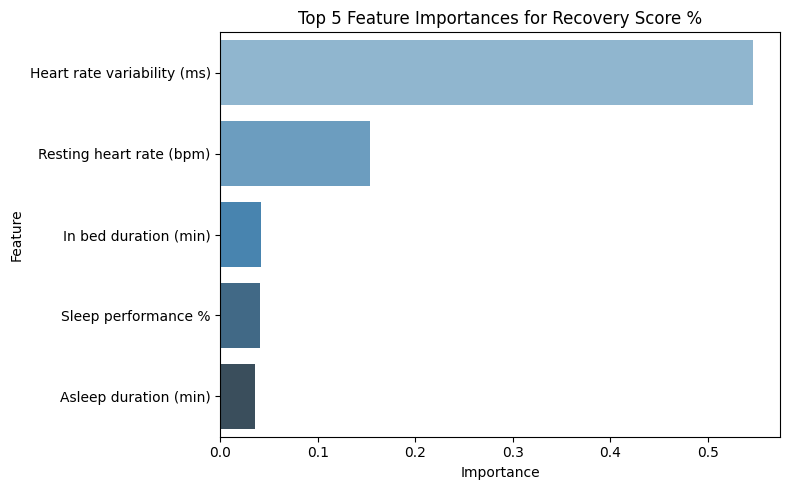

,Feature,Importance
1,Heart rate variability (ms),0.546984
0,Resting heart rate (bpm),0.153271
7,In bed duration (min),0.042025
4,Sleep performance %,0.040162
6,Asleep duration (min),0.035133
10,REM duration (min),0.031083
9,Deep (SWS) duration (min),0.015850
13,Sleep debt (min),0.014914
8,Light sleep duration (min),0.014910
5,Respiratory rate (rpm),0.014428


In [15]:
plot_feature_importance(xgb_model, X)

In [16]:
X_test, y_test = model_prep(test_df_clean)
X_test.columns

Index(['Resting heart rate (bpm)', 'Heart rate variability (ms)',
       'Skin temp (celsius)', 'Blood oxygen %', 'Sleep performance %',
       'Respiratory rate (rpm)', 'Asleep duration (min)',
       'In bed duration (min)', 'Light sleep duration (min)',
       'Deep (SWS) duration (min)', 'REM duration (min)',
       'Awake duration (min)', 'Sleep need (min)', 'Sleep debt (min)',
       'Sleep efficiency %', 'Deep sleep ratio', 'REM sleep ratio',
       'Light sleep ratio'],
      dtype='object')

In [17]:
test_preds = xgb_model.predict(X_test)
len(test_preds)

128

In [18]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

In [19]:
print(f"Test Set Performance:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")

Test Set Performance:
Test RMSE: 6.6193
Test MAE: 5.3738
Test R2: 0.9097


In [20]:
def eval_model(model, X_test, y_test):
    test_preds = model.predict(X_test)

    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    test_r2 = r2_score(y_test, test_preds)

    print(f"Test Set Performance:")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R2: {test_r2:.4f}")

In [21]:
eval_model(xgb_model, X_test, y_test)

Test Set Performance:
Test RMSE: 6.6193
Test MAE: 5.3738
Test R2: 0.9097


In [22]:
import joblib

In [23]:
joblib.dump(xgb_model, 'xgboost_model_personal.joblib')

['xgboost_model_personal.joblib']